In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 3445, done.
remote: Counting objects: 100% (1055/1055), done.
remote: Compressing objects: 100% (388/388), done.
remote: Total 3445 (delta 707), reused 996 (delta 664), pack-reused 2390
Receiving objects: 100% (3445/3445), 43.22 MiB | 30.86 MiB/s, done.
Resolving deltas: 100% (2202/2202), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
! pip install --upgrade polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 44.7 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.15
    Uninstalling polars-0.20.15:
      Successfully uninstalled polars-0.20.15


In [4]:
! pip install simsimd scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.2/382.2 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import (
    _preprocessing_history_trendiness_scores, 
    add_history_trendiness_scores_feature, 
    _preprocessing_mean_delay_features, 
    add_mean_delays_features, 
    _preprocessing_window_features, 
    add_window_features, 
    add_trendiness_feature_categories, 
    _preprocessing_article_endorsement_feature, 
    get_unique_categories,
    add_trendiness_feature,
    _preprocessing_article_endorsement_feature_by_article_and_user,
)

from catboost import CatBoostClassifier

2024-05-19 15:31:08.627645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 15:31:08.627872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 15:31:08.786353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Memory Utils

In [6]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.8669


In [7]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [8]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 1.127


# Articles Preprocessing

In [9]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')),
    pl.col('topics').list.len().alias('num_topics'),
    (pl.col('total_pageviews') / pl.col('total_inviews')).alias('total_pageviews/inviews')
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 58.23 MB
Memory usage after optimization is: 58.00 MB
Decreased by 0.4%

RAM memory GB usage = 1.136


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null


In [10]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['MISC', 'EVENT', 'ORG', 'PER', 'LOC', 'PROD']

In [11]:
# in case of two category_str for the same category, one of the two is picked
unique_categories_df = articles.select(['category', 'category_str']).unique('category').drop_nulls('category')
unique_categories = {
    row['category']: row['category_str'] for row in unique_categories_df.iter_rows(named=True)
}
unique_categories

{539: 'ferie',
 572: 'side9',
 2504: 'bibliotek',
 2975: 'penge',
 140: 'krimi',
 414: 'underholdning',
 2341: 'plus',
 2889: 'auto',
 2737: 'podcast',
 561: 'haandvaerkeren',
 2731: 'dagsorden',
 498: 'musik',
 22: 'horoskoper',
 1505: 'vin',
 457: 'forbrug',
 142: 'sport',
 2077: 'opinionen',
 731: 'services',
 2: 'incoming',
 806: 'om_ekstra_bladet',
 118: 'nyheder',
 529: 'biler',
 565: 'sex_og_samliv',
 512: 'nationen',
 68: 'video'}

Mapping sentiment labels to -1, 0, 1 to save memory in the history dataframe.
Taking only article_default type and mapping it to 0/1 since after only this is needed (and it saves memory) for the history at the moment

In [12]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 1.148


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32]
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]"


In [14]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Topic Model

In [15]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [16]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# parameters tuned on perplexity
N_COMPONENTS = 5
lda_model = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    doc_topic_prior=0.99,
    topic_word_prior=0.75,
    learning_method='online'
)
articles = articles.with_columns(
    pl.Series(lda_model.fit_transform(titles_bow).astype(np.float32)) \
        .list.to_array(5).alias('topic_model_embeddings')
)
articles.head(2)

CPU times: user 39 s, sys: 11.7 ms, total: 39 s
Wall time: 39 s


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embeddings
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],"array[f32, 5]"
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]","[0.143661, 0.287448, … 0.143754]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]","[0.3674, 0.14741, … 0.111524]"


In [17]:
topic_model_columns = [f'topic_model_embedding_{i}' for i in range(N_COMPONENTS)]

articles = articles.with_columns(
    pl.col('topic_model_embeddings').arr.to_struct(fields=lambda i: f'topic_model_embedding_{i}')
).with_columns([
    pl.col('topic_model_embeddings').struct.field(f'topic_model_embedding_{i}') for i in range(N_COMPONENTS)
]).drop('topic_model_embeddings')

articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embedding_0,topic_model_embedding_1,topic_model_embedding_2,topic_model_embedding_3,topic_model_embedding_4
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],f32,f32,f32,f32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]",0.143661,0.287448,0.281401,0.143737,0.143754
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]",0.3674,0.14741,0.262766,0.1109,0.111524


# History preprocessing

In [18]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [19]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:17,  1.10s/it]                        



RAM memory GB usage = 1.272
Memory usage of dataframe is 39.38 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 21 s, sys: 1.84 s, total: 22.8 s
Wall time: 18.6 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,MISCPct,EVENTPct,ORGPct,PERPct,LOCPct,PRODPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,3,16,"[0.016041, 0.062928, … 0.178427]",0.223776,0.202797,0.888112,0.874126,0.804196,0.237762
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.117424,0.087121,0.852273,0.787879,0.776515,0.318182


In [20]:
history_train.shape

(15143, 27)

# Named entity collaborative filtering

In [21]:
user_id_mapping = history_train.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_mapping = articles.select(['ner_clusters']) \
    .explode('ner_clusters') \
    .rename({'ner_clusters': 'ner'}) \
    .with_columns(pl.col('ner').str.strip_chars_start('\" ').str.to_lowercase()) \
    .unique('ner').drop_nulls().filter(pl.col('ner').str.len_chars() > 0) \
    .sort('ner').with_row_index().rename({'index': 'ner_index'})

In [22]:
ner_interactions = history_train.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_train.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [23]:
%cd /kaggle/working
! git clone https://github.com/MaurizioFD/RecSys_Course_AT_PoliMi.git

/kaggle/working


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'RecSys_Course_AT_PoliMi'...
remote: Enumerating objects: 1519, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1519 (delta 223), reused 220 (delta 212), pack-reused 1264
Receiving objects: 100% (1519/1519), 50.33 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (909/909), done.


In [24]:
%cd /kaggle/working/RecSys_Course_AT_PoliMi

from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Evaluation.Evaluator import EvaluatorHoldout

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

/kaggle/working/RecSys_Course_AT_PoliMi
ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 161.87 column/sec. Elapsed time 4.51 min
EvaluatorHoldout: Ignoring 31 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15112 (100.0%) in 46.16 sec. Users per second: 327


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.311971,0.312913,0.030088,0.214433,0.214676,0.469902,0.319612,0.054883,0.766609,0.953152,...,0.997953,0.76504,0.997953,0.002086,5.362616,0.952586,0.016842,0.419597,3.357942,0.009295


In [25]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 18909 (43.2%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.78 sec
EvaluatorHoldout: Processed 15112 (100.0%) in 25.30 sec. Users per second: 597


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.342628,0.345141,0.048661,0.261759,0.263204,0.670397,0.392258,0.085219,0.858655,1.275579,...,0.997953,0.856898,0.997953,0.001871,5.929536,0.95823,0.015104,0.463956,3.324192,0.009294


In [26]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_train.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_train.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).max().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 4min 13s, sys: 2min 56s, total: 7min 9s
Wall time: 1min 59s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
271497650,9773985,0.009021,0.029862,0.035755,0.006402,0.021341,0.021728
326174770,9774392,0.163173,0.435129,0.643493,0.124735,0.332628,0.478398
574156388,9773078,0.010904,0.070875,0.056352,0.012042,0.078273,0.055797
465067907,9709326,0.080384,0.066987,0.215372,0.146108,0.138695,0.399197
415509138,9485931,0.457394,0.251279,1.0,0.26315,0.245607,0.960599


In [27]:
del URM_ner
del URM_ner_test
del ner_inview_scores
del ner_interactions
del ner_interactions_test
gc.collect()

0

# Creating Training Dataframe

In [28]:
def normalize_endorsement(articles_endorsement_raw):
    return articles_endorsement.sort(by='impression_time').with_columns(
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').sum().over('impression_time')
        ).alias('normalized_endorsement_10h'),
        (
            pl.col('endorsement_10h') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_10h_diff_rolling'),
        (
            pl.col('endorsement_10h').rolling_mean(5, min_periods=1).over('article') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_macd'),
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').quantile(0.8).over('impression_time')
        ).alias('endorsement_quantile_norm_10h')
    ).with_columns(
        (
            pl.col('normalized_endorsement_10h') / 
            pl.col('normalized_endorsement_10h').rolling_max(10, min_periods=1).over('impression_time')
        ).alias('normalized_endorsement_10h_rolling_max_ratio'),
    )
    

def add_article_endorsement_feature(df_features, normalized_endorsement):
    # old return df_features.join(other=articles_endorsement, on=["article", "impression_time"], how="left")
    normalized_endorsement = normalized_endorsement.with_columns(pl.col('article').cast(pl.Int32))
    return df_features.with_columns(pl.col('impression_time').dt.round('1m').alias('rounded_impression_time'))\
                         .join(normalized_endorsement.rename({'impression_time' : 'rounded_impression_time'}), on=['article','rounded_impression_time'], how='left')\
                         .drop('rounded_impression_time')

In [29]:
def normalize_endorsement_by_article_and_user(articles_endorsement_articleuser_raw):
    return articles_endorsement_articleuser_raw.sort(by=['user_id','impression_time']).with_columns(
        (
            pl.col('endorsement_20h_articleuser') / 
            pl.col('endorsement_20h_articleuser').sum().over(['user_id','impression_time'])
        ).alias('normalized_endorsement_articleuser_20h'),
        (
            pl.col('endorsement_20h_articleuser') - 
            pl.col('endorsement_20h_articleuser').rolling_mean(10, min_periods=1).over(['article','user_id'])
        ).alias('endorsement_20h_articleuser_diff_rolling'),
        (
            pl.col('endorsement_20h_articleuser').rolling_mean(5, min_periods=1).over(['article','user_id']) - 
            pl.col('endorsement_20h_articleuser').rolling_mean(10, min_periods=1).over(['article','user_id'])
        ).alias('endorsement_articleuser_macd'),
        (
            pl.col('endorsement_20h_articleuser') / 
            pl.col('endorsement_20h_articleuser').quantile(0.8).over(['user_id','impression_time'])
        ).alias('endorsement_articleuser_quantile_norm_20h')
    ).with_columns(
        (
            pl.col('endorsement_20h_articleuser') / 
            pl.col('endorsement_20h_articleuser').rolling_max(10, min_periods=1).over(['user_id','impression_time'])
        ).alias('normalized_endorsement_articleuser_20h_rolling_max_ratio'),
    )
    

def add_article_endorsement_feature_by_article_and_user(df_features, normalized_endorsement):
    # old return df_features.join(other=articles_endorsement, on=["article", "impression_time"], how="left")
    normalized_endorsement = normalized_endorsement.with_columns(pl.col('article').cast(pl.Int32))
    return df_features.with_columns(pl.col('impression_time').dt.round('1m').alias('rounded_impression_time'))\
                         .join(normalized_endorsement.rename({'impression_time' : 'rounded_impression_time'}), on=['user_id','article','rounded_impression_time'], how='left')\
                         .drop('rounded_impression_time')

In [30]:
def add_article_endorsement_feature_leak(df_features, normalized_endorsement,period='10h'):
    # old return df_features.join(other=articles_endorsement, on=["article", "impression_time"], how="left")
    normalized_endorsement = normalized_endorsement.with_columns(pl.col('article').cast(pl.Int32)).rename({f'endorsement_{period}':f'endorsement_{period}_leak'}) \
                            .with_columns(
                                pl.col('impression_time') - pl.duration(hours=int(period[:-1]))
                            ).sort('impression_time').set_sorted('impression_time')
    
    return df_features.with_columns(pl.col('impression_time').dt.round('1m').alias('rounded_impression_time'))\
                        .sort('rounded_impression_time').set_sorted('rounded_impression_time') \
                         .join_asof(normalized_endorsement.rename({'impression_time' : 'rounded_impression_time'}),by='article', left_on='rounded_impression_time',right_on='rounded_impression_time', strategy='nearest')\
                         .drop('rounded_impression_time') \
                        .with_columns(
                            pl.col(f'endorsement_{period}_leak').fill_null(0)
                        )


In [31]:
def add_trendiness_feature_leak(df_features: pl.DataFrame, articles: pl.DataFrame, period: str = "3d"):

    topics = articles.select("topics").explode("topics").unique()
    topics = [topic for topic in topics["topics"] if topic is not None]
    # min_impression_time = df_features.select(pl.col("impression_time")).min().item()

    # topics_total_publications= articles.filter(pl.col("published_time")< min_impression_time ).select("topics") \
    # .explode("topics").group_by("topics").len()

    topics_popularity = articles.select(["published_time", "topics"]).with_columns(
        pl.col("published_time").dt.date().alias("published_date")
    ).drop("published_time").group_by("published_date").agg(
        pl.col("topics").flatten()
    ).sort("published_date").set_sorted("published_date").upsample(time_column="published_date", every="1d") \
        .rolling(index_column="published_date", period=period).agg(
        [pl.col("topics").list.count_matches(topic).sum().alias(
            f"{topic}_matches") for topic in topics]
    )

    return df_features.with_columns(
        pl.col("impression_time").dt.date().alias("impression_date")
    ).join(other=articles.select(["article_id", "topics"]), left_on="article", right_on="article_id", how="left") \
        .with_columns(
        [pl.col("topics").list.contains(topic).cast(
            pl.Int8).alias(f"{topic}_present") for topic in topics]
    ).sort('impression_date').set_sorted('impression_date') \
    .join_asof(topics_popularity.with_columns(pl.col('published_date') + pl.duration(days=1) - pl.duration(days=int(period[:-1]))) \
               .sort('published_date').set_sorted('published_date'),
               left_on="impression_date", right_on="published_date", strategy="nearest") \
        .with_columns(
        [pl.col(f"{topic}_present").mul(pl.col(f"{topic}_matches")).alias(
            f"trendiness_score_{topic}") for topic in topics]
    ).with_columns(
        pl.sum_horizontal([pl.col(f"trendiness_score_{topic}") for topic in topics]).alias(
            "trendiness_score_leak"),
    ).drop(
        [f"trendiness_score_{topic}" for topic in topics]
    ).drop(
        [f"{topic}_matches" for topic in topics]
    ).drop(
        [f"{topic}_present" for topic in topics]
    ).drop(["topics", "impression_date","published_date"])

In [32]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_train, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_train)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_train, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_train, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)
articles_endorsement_articleuser = _preprocessing_article_endorsement_feature_by_article_and_user(
    behaviors=behaviors_train, period="20h")
normalized_endorsement_articleuser = normalize_endorsement_by_article_and_user(articles_endorsement_articleuser)

topics = articles.select("topics").explode("topics").unique()
topics = [topic for topic in topics["topics"] if topic is not None]

history_counts=history_train.select(['article_id_fixed']).explode('article_id_fixed').group_by('article_id_fixed').len() \
.rename({'article_id_fixed':'article','len':'clicked_count'})

behaviors_counts=behaviors_train.select('article_ids_inview').explode('article_ids_inview').group_by('article_ids_inview').len() \
.rename({'article_ids_inview':'article','len':'inview_count'})

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .with_columns(pl.col('postcode').fill_null(5)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .pipe(add_trendiness_feature_leak, articles=articles, period='3d') \
    .rename({'trendiness_score_leak':'trendiness_score_3d_leak'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 
                            'total_pageviews/inviews', 'article_type']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours'),
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement) \
    .pipe(add_article_endorsement_feature_by_article_and_user, normalized_endorsement = normalized_endorsement_articleuser) \
    .pipe(add_article_endorsement_feature_leak, normalized_endorsement = normalized_endorsement) \
    .rename({
        "endorsement_10h_diff_rolling_right":"endorsement_10h_leak_diff_rolling",
        "endorsement_macd_right":"endorsement_leak_macd",
        "endorsement_quantile_norm_10h_right":"endorsement_quantile_norm_10h_leak",
        "normalized_endorsement_10h_rolling_max_ratio_right":"normalized_endorsement_10h_leak_rolling_max_ratio"
    }).join(history_counts, on='article',how='left') \
    .join(behaviors_counts , on='article', how='left')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()

16it [00:28,  1.81s/it]                        
2427it [00:05, 449.87it/s]                          
16it [00:02,  6.97it/s]
16it [00:02,  5.89it/s]                        
100%|██████████| 506/506 [00:05<00:00, 87.68it/s]



RAM memory GB usage = 3.144
Memory usage of dataframe is 1119.91 MB
Memory usage after optimization is: 661.24 MB
Decreased by 41.0%

RAM memory GB usage = 2.681
CPU times: user 12min 39s, sys: 1min 12s, total: 13min 52s
Wall time: 4min 12s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,…,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,endorsement_20h_articleuser,normalized_endorsement_articleuser_20h,endorsement_20h_articleuser_diff_rolling,endorsement_articleuser_macd,endorsement_articleuser_quantile_norm_20h,normalized_endorsement_articleuser_20h_rolling_max_ratio,endorsement_10h_leak,normalized_endorsement_10h_right,endorsement_10h_leak_diff_rolling,endorsement_leak_macd,endorsement_quantile_norm_10h_leak,normalized_endorsement_10h_leak_rolling_max_ratio,clicked_count,inview_count
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,…,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,u8,f32,f32,f32,f32,f32,i16,f32,f32,f32,f32,f32,u32,u16
338472617,9769457,2269270,2023-05-18 07:00:28,0,2,31.0,null,false,2,null,false,1409226,5,16,44,67,51,4,7,0.363636,0.238806,0.085437,false,2023-05-17 21:09:58,140,0.9937,"""Negative""",1,7,9,158,3,110230,518387,5.64879e6,0.21264,…,216.343109,169.969086,7.161615,174.870468,2.739003,68.56012,123,114,96,59,1,0,0,0,23,14,67,7,0.020958,0.0,0.0,1.0,0.466667,1,0.111111,0.0,0.0,1.0,1.0,753,0.006224,4.6,2.6,0.33128,0.332597,1559,860
550481897,9770741,2039130,2023-05-18 07:00:27,1,1,98.0,100.0,false,2,null,false,1679074,5,82,235,353,211,4,7,0.348936,0.232295,0.456311,false,2023-05-17 20:52:31,414,0.783,"""Negative""",2,4,6,240,5,140796,696710,5.168334e6,0.202087,…,237.067413,264.208557,17.690067,427.646942,11.719101,283.651672,55,34,21,20,1,0,0,0,7,35,49,11,0.032934,0.0,0.0,1.571429,0.6875,1,0.05,0.0,0.0,1.0,1.0,766,0.006883,-348.0,-36.400002,0.359793,0.151383,1936,1326
579742841,9763284,362240,2023-05-18 07:00:07,0,1,88.0,null,false,2,null,false,1771620,5,118,336,629,340,4,7,0.35119,0.187599,0.652427,false,2023-05-18 04:19:17,142,0.9862,"""Negative""",2,8,1,219,4,66034,336785,4.619203e6,0.196072,…,192.800003,345.11554,3.963758,97.589859,0.266667,10.666667,15,0,0,0,1,0,0,0,3,12,110,6,0.017964,0.0,0.0,0.857143,0.4,1,0.030303,0.0,0.0,1.0,1.0,870,0.007191,4.6,2.6,0.382754,0.330296,755,980
45936619,9770538,2052447,2023-05-18 07:00:18,0,2,56.0,100.0,false,2,null,false,1192949,5,61,202,355,209,4,7,0.30198,0.171831,0.392233,false,2023-05-18 05:57:20,498,0.6058,"""Negative""",2,10,18,597,6,63862,368843,4.991874e6,0.173141,…,207.793106,282.398804,7.871868,191.826935,2.357759,58.120689,108,95,50,15,1,0,0,0,2,54,9,16,0.047904,0.0,0.0,2.285714,1.0,1,0.083333,0.0,0.0,1.0,1.0,1526,0.014948,4.5,2.5,0.828447,0.609668,554,1792
450331134,9727087,955346,2023-05-18 07:00:08,0,3,325.0,100.0,false,2,null,false,1657450,5,77,217,385,129,4,7,0.354839,0.2,0.421359,true,2023-04-24 09:46:42,118,0.6239,"""Neutral""",5,7,29,721,5,81411,1139178,4.614807e6,0.071465,…,233.199997,364.027435,6.206751,151.412888,0.0,1.616667,24,18,16,9,1,0,0,0,8,12,96,17,0.050898,0.0,0.0,2.428571,1.0,1,0.142857,0.0,0.0,1.0,1.0,2121,0.018005,5.7,3.5,0.923781,0.891176,184,2126


In [33]:
train_ds.shape

(2585747, 89)

## Session Features

In [34]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [35]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration', 
              'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 2.691
CPU times: user 1.97 s, sys: 152 ms, total: 2.12 s
Wall time: 1.6 s


session_id,last_session_time,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],i64,list[i32],f64
715484,2023-05-17 20:51:28,0,[9769471],0.0
200372,2023-05-18 06:32:27,0,[9735909],8.0


In [36]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 3.052


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,…,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,endorsement_20h_articleuser,normalized_endorsement_articleuser_20h,endorsement_20h_articleuser_diff_rolling,endorsement_articleuser_macd,endorsement_articleuser_quantile_norm_20h,normalized_endorsement_articleuser_20h_rolling_max_ratio,endorsement_10h_leak,normalized_endorsement_10h_right,endorsement_10h_leak_diff_rolling,endorsement_leak_macd,endorsement_quantile_norm_10h_leak,normalized_endorsement_10h_leak_rolling_max_ratio,clicked_count,inview_count,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,…,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,u8,f32,f32,f32,f32,f32,i16,f32,f32,f32,f32,f32,u32,u16,i64,f64,i64,bool,bool
338472617,9769457,2269270,2023-05-18 07:00:28,0,2,31.0,null,false,2,null,false,5,16,44,67,51,4,7,0.363636,0.238806,0.085437,false,140,0.9937,"""Negative""",1,7,9,158,3,110230,518387,5.64879e6,0.21264,"""article_default""",0,…,68.56012,123,114,96,59,1,0,0,0,23,14,67,7,0.020958,0.0,0.0,1.0,0.466667,1,0.111111,0.0,0.0,1.0,1.0,753,0.006224,4.6,2.6,0.33128,0.332597,1559,860,2,1.0,-6,true,false
550481897,9770741,2039130,2023-05-18 07:00:27,1,1,98.0,100.0,false,2,null,false,5,82,235,353,211,4,7,0.348936,0.232295,0.456311,false,414,0.783,"""Negative""",2,4,6,240,5,140796,696710,5.168334e6,0.202087,"""article_default""",0,…,283.651672,55,34,21,20,1,0,0,0,7,35,49,11,0.032934,0.0,0.0,1.571429,0.6875,1,0.05,0.0,0.0,1.0,1.0,766,0.006883,-348.0,-36.400002,0.359793,0.151383,1936,1326,0,0.75,-75,true,false


In [37]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.559252,0.023921


In [38]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [39]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 701.62 MB
Memory usage after optimization is: 649.53 MB
Decreased by 7.4%

RAM memory GB usage = 2.944
CPU times: user 1.96 s, sys: 628 ms, total: 2.58 s
Wall time: 2.32 s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,…,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,endorsement_20h_articleuser,normalized_endorsement_articleuser_20h,endorsement_20h_articleuser_diff_rolling,endorsement_articleuser_macd,endorsement_articleuser_quantile_norm_20h,normalized_endorsement_articleuser_20h_rolling_max_ratio,endorsement_10h_leak,normalized_endorsement_10h_right,endorsement_10h_leak_diff_rolling,endorsement_leak_macd,endorsement_quantile_norm_10h_leak,normalized_endorsement_10h_leak_rolling_max_ratio,clicked_count,inview_count,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,…,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,u8,f32,f32,f32,f32,f32,i16,f32,f32,f32,f32,f32,u32,u16,i8,f32,i16,bool,bool,f32
338472617,9769457,2269270,2023-05-17,0,2,31.0,null,false,2,null,false,5,16,44,67,51,4,7,0.363636,0.238806,0.085437,false,140,0.9937,"""Negative""",1,7,9,158,3,110230,518387,5.64879e6,0.21264,"""article_default""",0,…,123,114,96,59,1,0,0,0,23,14,67,7,0.020958,0.0,0.0,1.0,0.466667,1,0.111111,0.0,0.0,1.0,1.0,753,0.006224,4.6,2.6,0.33128,0.332597,1559,860,2,1.0,-6,true,false,0.214286
550481897,9770741,2039130,2023-05-17,1,1,98.0,100.0,false,2,null,false,5,82,235,353,211,4,7,0.348936,0.232295,0.456311,false,414,0.783,"""Negative""",2,4,6,240,5,140796,696710,5.168334e6,0.202087,"""article_default""",0,…,55,34,21,20,1,0,0,0,7,35,49,11,0.032934,0.0,0.0,1.571429,0.6875,1,0.05,0.0,0.0,1.0,1.0,766,0.006883,-348.0,-36.400002,0.359793,0.151383,1936,1326,0,0.75,-75,true,false,0.134921


# Adding history features

In [40]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def list_pct_matches_with_constant(a, value) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with a constant value.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise(pl.col(a).list.count_matches(value) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_train.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)
train_ds = reduce_polars_df_memory_size(train_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

259it [38:25,  8.90s/it]


Memory usage of dataframe is 1700.14 MB
Memory usage after optimization is: 1317.91 MB
Decreased by 22.5%

RAM memory GB usage = 5.024


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,MostFrequentWeekday,MostFrequentHour,MISCPct,EVENTPct,ORGPct,PERPct,LOCPct,PRODPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_ferie_Pct,Category_side9_Pct,Category_bibliotek_Pct,Category_penge_Pct,Category_krimi_Pct,Category_underholdning_Pct,Category_plus_Pct,Category_auto_Pct,Category_podcast_Pct,Category_haandvaerkeren_Pct,Category_dagsorden_Pct,Category_musik_Pct,Category_horoskoper_Pct,Category_vin_Pct,Category_forbrug_Pct,Category_sport_Pct,Category_opinionen_Pct,Category_services_Pct,Category_incoming_Pct,Category_om_ekstra_bladet_Pct,Category_nyheder_Pct,Category_biler_Pct,Category_sex_og_samliv_Pct,Category_nationen_Pct,Category_video_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
121091910,9767534,875162,0,1,74.0,null,false,2,null,false,5,29,114,169,103,4,7,0.254386,0.171598,0.221359,false,140,0.7544,"""Negative""",1,6,21,212,5,215654,1205903,1.0432497e7,0.178832,"""article_default""",1,34,…,4,13,0.128405,0.14786,0.964981,0.883268,0.649805,0.276265,0.228058,false,8,0.972763,0.0,0.0,0.0,0.003891,0.175097,0.229572,0.0,0.0,0.0,0.0,0.0,0.003891,0.0,0.0,0.011673,0.081712,0.0,0.0,0.0,0.0,0.44358,0.0,0.0,0.050584,0.0
62391918,9099237,564801,0,2,44.0,null,false,2,null,false,5,128,371,513,302,4,7,0.345013,0.249513,0.720388,true,140,0.9951,"""Negative""",4,8,27,842,6,null,null,null,null,"""article_default""",476,11435,…,4,14,0.125,0.1328125,0.9375,0.921875,0.75,0.3359375,0.527687,false,8,0.9453125,0.0078125,0.0,0.0,0.0,0.2734375,0.265625,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0078125,0.1015625,0.0,0.0,0.0,0.0,0.2890625,0.0,0.0,0.0390625,0.0


In [41]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d','trendiness_score_5d', 'endorsement_10h', 
    'total_pageviews/inviews', 'mean_JS','mean_topic_model_cosine', 'topics_cosine',
    'article_delay_hours', 'total_pageviews','total_inviews', 'trendiness_score_category',
    'std_JS', 'total_read_time', 'endorsement_10h_leak',"trendiness_score_3d_leak",
    "clicked_count","inview_count",
]
RANK_IMPRESSION_DESCENDING = [
    'trendiness_score_3d','trendiness_score_5d', 'endorsement_10h', 
    'total_pageviews/inviews', 'mean_JS', 'mean_topic_model_cosine', 'topics_cosine',
    'total_pageviews', 'total_read_time','total_inviews', 'trendiness_score_category',
    'endorsement_10h_leak',"trendiness_score_3d_leak","clicked_count","inview_count"
]
RANK_IMPRESSION_ASCENDING = [
    'article_delay_hours', 'std_JS', 'mean_topics_mean_delay_hours'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
LIST_DIVERSITY = [
    'category', 'sentiment_label', 'article_type'
]
NORMALIZE_OVER_ARTICLE_AND_USER_ID= ['endorsement_20h_articleuser']

expressions = [
    [(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    [pl.col(c).rank(method='min').over(pl.col('impression_id')).alias(f'{c}_rank_impression')
     for c in RANK_IMPRESSION_ASCENDING],
    [pl.col(c).rank(method='min', descending=True).over(pl.col('impression_id')).alias(f'{c}_rank_impression')
     for c in RANK_IMPRESSION_DESCENDING],
    [pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    [pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    [pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    [pl.col(c).entropy().over(pl.col('impression_id')).alias(f'entropy_impression_{c}')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    [(pl.col(c) - pl.col(c).median().over(pl.col('impression_id'))).alias(f'{c}_minus_median_impression')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    [(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
     for c in NORMALIZE_OVER_USER_ID],
    [(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
     for c in NORMALIZE_OVER_ARTICLE],
    [pl.col(c).n_unique().over('impression_id').alias(f'{c}_diversity_impression')
     for c in LIST_DIVERSITY],
    [(pl.col(c) / pl.col(c).max().over([pl.col('article'),pl.col('user_id')])).alias(f'{c}_l_inf_article_user')
     for c in NORMALIZE_OVER_ARTICLE_AND_USER_ID],
]
    
for expressions_group in tqdm.tqdm(expressions):
    train_ds = train_ds.with_columns(expressions_group)
    train_ds = reduce_polars_df_memory_size(train_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage of dataframe is 1595.64 MB


  8%|▊         | 1/12 [00:07<01:18,  7.11s/it]

Memory usage after optimization is: 1487.14 MB
Decreased by 6.8%
Memory usage of dataframe is 1517.04 MB


 17%|█▋        | 2/12 [00:10<00:50,  5.05s/it]

Memory usage after optimization is: 1503.06 MB
Decreased by 0.9%
Memory usage of dataframe is 1652.56 MB


 25%|██▌       | 3/12 [00:21<01:09,  7.67s/it]

Memory usage after optimization is: 1578.58 MB
Decreased by 4.5%
Memory usage of dataframe is 1856.31 MB


 33%|███▎      | 4/12 [00:25<00:48,  6.09s/it]

Memory usage after optimization is: 1747.81 MB
Decreased by 5.8%
Memory usage of dataframe is 2084.72 MB


 42%|████▏     | 5/12 [00:37<00:59,  8.46s/it]

Memory usage after optimization is: 1917.03 MB
Decreased by 8.0%
Memory usage of dataframe is 2253.94 MB


 50%|█████     | 6/12 [00:50<00:59,  9.95s/it]

Memory usage after optimization is: 2086.26 MB
Decreased by 7.4%
Memory usage of dataframe is 2362.45 MB


 58%|█████▊    | 7/12 [01:01<00:51, 10.20s/it]

Memory usage after optimization is: 2253.94 MB
Decreased by 4.6%
Memory usage of dataframe is 2531.67 MB


 67%|██████▋   | 8/12 [01:07<00:35,  8.94s/it]

Memory usage after optimization is: 2423.17 MB
Decreased by 4.3%
Memory usage of dataframe is 2462.63 MB


 75%|███████▌  | 9/12 [01:10<00:20,  6.89s/it]

Memory usage after optimization is: 2462.63 MB
Decreased by 0.0%
Memory usage of dataframe is 2521.81 MB


 83%|████████▎ | 10/12 [01:12<00:11,  5.56s/it]

Memory usage after optimization is: 2511.95 MB
Decreased by 0.4%
Memory usage of dataframe is 2541.54 MB


 92%|█████████▏| 11/12 [01:15<00:04,  4.81s/it]

Memory usage after optimization is: 2519.34 MB
Decreased by 0.9%
Memory usage of dataframe is 2539.07 MB


100%|██████████| 12/12 [01:18<00:00,  6.55s/it]

Memory usage after optimization is: 2529.21 MB
Decreased by 0.4%

RAM memory GB usage = 5.335


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,entropy_impression_trendiness_score_category,entropy_impression_std_JS,entropy_impression_total_read_time,entropy_impression_endorsement_10h_leak,entropy_impression_trendiness_score_3d_leak,entropy_impression_clicked_count,entropy_impression_inview_count,trendiness_score_3d_minus_median_impression,trendiness_score_5d_minus_median_impression,endorsement_10h_minus_median_impression,total_pageviews/inviews_minus_median_impression,mean_JS_minus_median_impression,mean_topic_model_cosine_minus_median_impression,topics_cosine_minus_median_impression,article_delay_hours_minus_median_impression,total_pageviews_minus_median_impression,total_inviews_minus_median_impression,trendiness_score_category_minus_median_impression,std_JS_minus_median_impression,total_read_time_minus_median_impression,endorsement_10h_leak_minus_median_impression,trendiness_score_3d_leak_minus_median_impression,clicked_count_minus_median_impression,inview_count_minus_median_impression,mean_JS_l_inf_user,std_JS_l_inf_user,mean_topic_model_cosine_l_inf_user,topics_cosine_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,mean_topic_model_cosine_l_inf_article,topics_cosine_l_inf_article,category_diversity_impression,sentiment_label_diversity_impression,article_type_diversity_impression,endorsement_20h_articleuser_l_inf_article_user
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,f32
121091910,9767534,875162,0,1,74.0,null,false,2,null,false,5,29,114,169,103,4,7,0.254386,0.171598,0.221359,false,140,0.7544,"""Negative""",1,6,21,212,5,215654,1205903,1.0432497e7,0.178832,"""article_default""",1,34,…,NaN,3.081249,2.996482,2.975051,2.928252,2.973161,2.354722,-10.5,-34.0,-24.0,-0.013011,-0.017851,-0.003427,-0.022864,25.0,105228.5,646619.5,0.0,0.010292,4715823.5,-49.0,-0.5,1668.0,731.5,0.319105,0.492546,0.878214,0.353752,0.202381,0.231707,0.326691,0.851501,0.313236,8,3,2,0.5
62391918,9099237,564801,0,2,44.0,null,false,2,null,false,5,128,371,513,302,4,7,0.345013,0.249513,0.720388,true,140,0.9951,"""Negative""",4,8,27,842,6,null,null,null,null,"""article_default""",476,11435,…,2.45574,2.555982,2.144987,2.59707,2.434113,2.208455,2.521904,205.0,306.0,-54.0,null,0.09076,0.0,0.367549,11433.0,null,null,0.0,0.013911,null,-873.0,193.0,-427.5,2724.0,0.886032,0.38287,0.905821,1.0,0.990386,0.528518,0.512286,0.865851,0.700594,8,3,2,1.0


# Training

In [42]:
# subsample dataset

behaviors_subsample = behaviors_train.select(['impression_id','user_id','article_ids_inview','article_ids_clicked']) \
    .pipe(
        sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
    ).explode('article_ids_inview').drop('article_ids_clicked').rename({'article_ids_inview' : 'article'}) \
    .with_columns(pl.col('user_id').cast(pl.UInt32), pl.col('article').cast(pl.Int32)) \
    .select(['impression_id', 'user_id', 'article'])

train_ds = behaviors_subsample.join(train_ds, on=['impression_id','user_id','article'], how='left')
train_ds.head()

impression_id,user_id,article,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,entropy_impression_trendiness_score_category,entropy_impression_std_JS,entropy_impression_total_read_time,entropy_impression_endorsement_10h_leak,entropy_impression_trendiness_score_3d_leak,entropy_impression_clicked_count,entropy_impression_inview_count,trendiness_score_3d_minus_median_impression,trendiness_score_5d_minus_median_impression,endorsement_10h_minus_median_impression,total_pageviews/inviews_minus_median_impression,mean_JS_minus_median_impression,mean_topic_model_cosine_minus_median_impression,topics_cosine_minus_median_impression,article_delay_hours_minus_median_impression,total_pageviews_minus_median_impression,total_inviews_minus_median_impression,trendiness_score_category_minus_median_impression,std_JS_minus_median_impression,total_read_time_minus_median_impression,endorsement_10h_leak_minus_median_impression,trendiness_score_3d_leak_minus_median_impression,clicked_count_minus_median_impression,inview_count_minus_median_impression,mean_JS_l_inf_user,std_JS_l_inf_user,mean_topic_model_cosine_l_inf_user,topics_cosine_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,mean_topic_model_cosine_l_inf_article,topics_cosine_l_inf_article,category_diversity_impression,sentiment_label_diversity_impression,article_type_diversity_impression,endorsement_20h_articleuser_l_inf_article_user
u32,u32,i32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,f32
149474,139836,9778728,0,2,13.0,null,false,2,null,false,5,150,521,836,419,3,7,0.287908,0.179426,0.880068,false,142,0.9654,"""Negative""",1,5,18,251,7,22415,220247,1.004828e6,0.101772,"""article_default""",0,0,…,1.612282,1.739272,1.558951,1.774823,1.725289,-0.0,1.76343,281.5,447.5,-873.5,-0.111306,-0.005177,0.044569,-0.02667,-1.0,-62463.5,-165503.0,4.0,-0.033664,-4.981345e6,5.0,165.5,null,-886.0,0.447581,0.403328,0.901141,0.36119,0.0,0.233531,0.335164,0.887796,0.301919,4,3,1,1.0
149474,139836,9778669,0,2,13.0,null,false,2,null,false,5,85,199,313,266,3,7,0.427136,0.271565,0.336149,false,118,0.9481,"""Negative""",1,5,11,150,4,74491,373488,4.365609e6,0.199447,"""article_default""",0,1,…,1.612282,1.739272,1.558951,1.774823,1.725289,-0.0,1.76343,-40.5,-75.5,179.5,-0.013631,0.003967,-0.088519,0.015762,0.0,-10387.5,-12262.0,0.0,0.028015,-1.620564e6,-397.0,12.5,null,-56.0,0.501163,0.632488,0.747915,0.437299,0.043478,0.266627,0.511387,0.769129,0.319083,4,3,1,1.0
149474,139836,9778657,1,2,13.0,null,false,2,null,false,5,45,117,183,138,3,7,0.384615,0.245902,0.197635,false,118,0.8347,"""Neutral""",2,6,31,336,3,108389,478098,7.606737e6,0.226709,"""article_default""",0,1,…,1.612282,1.739272,1.558951,1.774823,1.725289,-0.0,1.76343,-122.5,-205.5,368.5,0.013631,0.05309,0.013098,0.218611,0.0,23510.5,92348.0,0.0,0.051035,1.620564e6,-5.0,-115.5,null,276.0,0.78901,0.718014,0.864908,0.801144,0.066667,0.350947,0.730242,0.871844,0.604487,4,3,1,1.0
150528,143471,9778682,0,2,25.0,null,false,2,null,false,5,69,206,334,201,3,7,0.334951,0.206587,0.347973,false,498,0.9546,"""Negative""",1,5,20,267,3,143520,455723,9.298546e6,0.314928,"""article_default""",0,1,…,1.924178,2.126514,2.008478,2.181736,2.013598,-0.0,2.173429,7.0,21.0,204.0,0.088219,0.013219,0.007987,-0.001332,1.0,48254.0,82235.0,-47.0,0.013249,4.223417e6,160.0,0.0,null,498.0

In [43]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory',
                       'article_type', 'postcode']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [44]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 7.464


In [45]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=1000, rsm=0.7, subsample=0.5)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.169254
0:	learn: 0.6446421	total: 1.19s	remaining: 19m 47s
25:	learn: 0.5072057	total: 28.8s	remaining: 17m 59s
50:	learn: 0.4909536	total: 56s	remaining: 17m 21s
75:	learn: 0.4810909	total: 1m 23s	remaining: 16m 54s
100:	learn: 0.4725070	total: 1m 50s	remaining: 16m 27s
125:	learn: 0.4659229	total: 2m 18s	remaining: 16m 1s
150:	learn: 0.4608740	total: 2m 46s	remaining: 15m 34s
175:	learn: 0.4566902	total: 3m 13s	remaining: 15m 5s
200:	learn: 0.4528040	total: 3m 40s	remaining: 14m 37s
225:	learn: 0.4491018	total: 4m 9s	remaining: 14m 14s
250:	learn: 0.4459161	total: 4m 38s	remaining: 13m 49s
275:	learn: 0.4431290	total: 5m 5s	remaining: 13m 20s
300:	learn: 0.4403415	total: 5m 32s	remaining: 12m 51s
325:	learn: 0.4377924	total: 5m 58s	remaining: 12m 21s
350:	learn: 0.4357075	total: 6m 25s	remaining: 11m 53s
375:	learn: 0.4336355	total: 6m 52s	remaining: 11m 25s
400:	learn: 0.4315223	total: 7m 32s	remaining: 11m 16s
425:	learn: 0.4296479	total: 8m	remaining: 10m 47

In [46]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 12.9 s, sys: 914 ms, total: 13.8 s
Wall time: 13.7 s


Text(0.5, 1.0, 'Catboost Feature Importances')

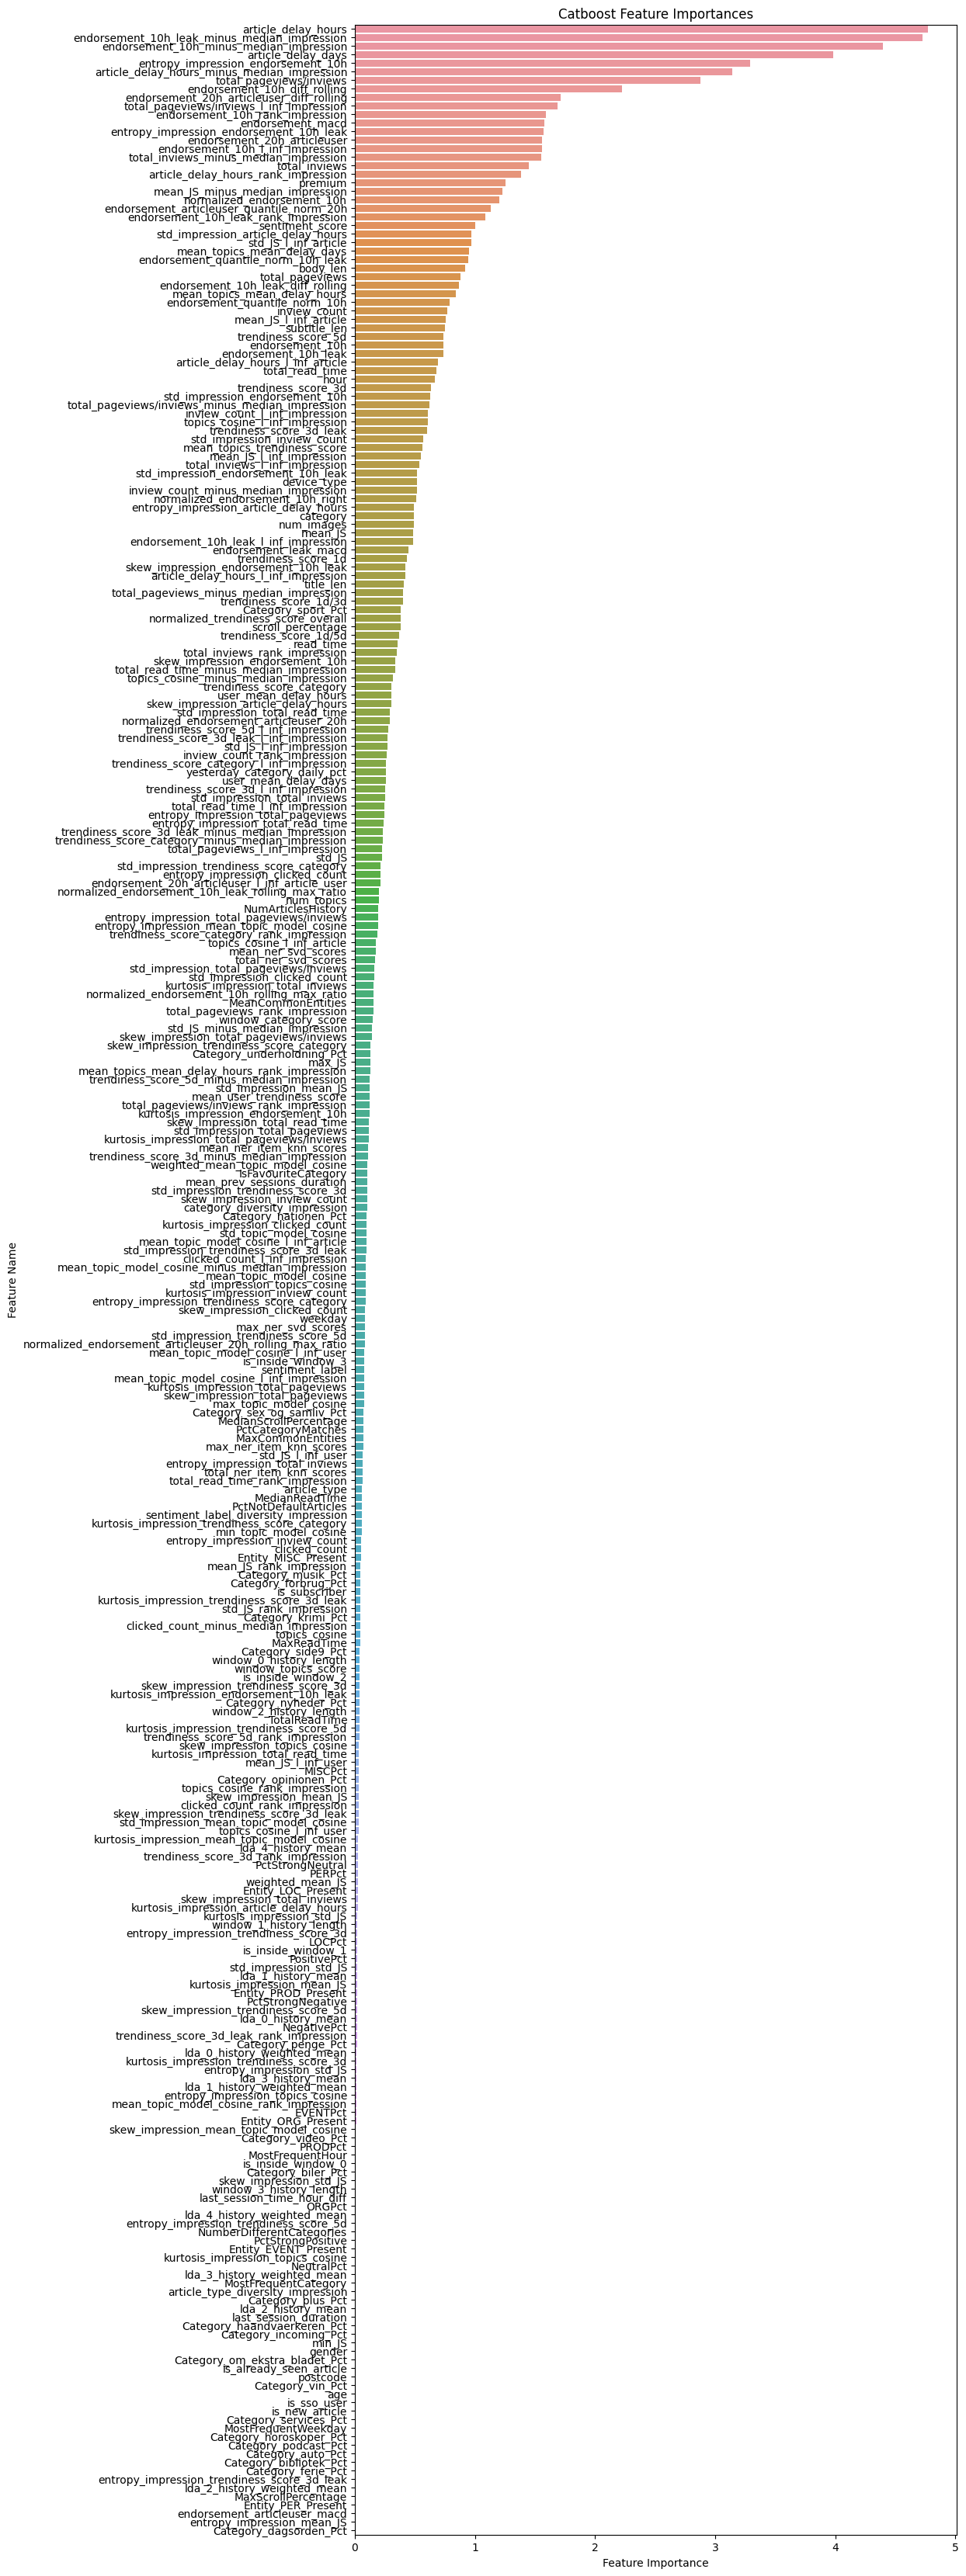

In [47]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 42))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [48]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 8.472


# Model Evaluation

In [49]:
user_id_mapping = history_val.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_interactions = history_val.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_val.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [50]:
item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 19035 (43.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 163.85 column/sec. Elapsed time 4.45 min
EvaluatorHoldout: Ignoring 32 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15310 (100.0%) in 48.12 sec. Users per second: 318


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.338445,0.339461,0.033197,0.241643,0.241977,0.493913,0.346767,0.060464,0.784651,1.033204,...,0.997914,0.783014,0.997914,0.002568,5.473111,0.953841,0.020621,0.428217,3.43338,0.010093


In [51]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 3 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 19035 (43.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.46 sec
EvaluatorHoldout: Processed 15310 (100.0%) in 26.39 sec. Users per second: 580


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.365382,0.368539,0.050795,0.283615,0.285707,0.695447,0.415659,0.089191,0.876486,1.342637,...,0.997914,0.874658,0.997914,0.001527,5.728555,0.954883,0.012263,0.448203,3.536612,0.010003


In [52]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_val.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_val.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).sum().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l_inf normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 4min 7s, sys: 2min 49s, total: 6min 56s
Wall time: 1min 55s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
174896690,9759345,0.199597,0.116014,0.042905,0.17434,0.096341,0.032586
471475077,9778943,0.004077,0.010238,0.009983,0.001392,0.003609,0.003379
222975202,9788197,0.018995,0.043779,0.033185,0.024011,0.056221,0.040219
222888264,9770369,0.029763,0.059531,0.024754,0.024067,0.045604,0.021138
293996662,9780384,0.027967,0.053956,0.038489,0.03736,0.070203,0.049675


In [53]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:16,  1.01s/it]                        



RAM memory GB usage = 9.075
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 19.7 s, sys: 1.32 s, total: 21 s
Wall time: 17.2 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,MISCPct,EVENTPct,ORGPct,PERPct,LOCPct,PRODPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.266667,0.3,0.913333,0.893333,0.846667,0.213333
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,4,7,"[0.0, 0.048524, … 0.217846]",0.192982,0.114035,0.947368,0.807018,0.815789,0.254386


In [54]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration',
              'all_seen_articles', 'mean_prev_sessions_duration'])

In [55]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_val, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_val)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_val, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_val, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)
articles_endorsement_articleuser = _preprocessing_article_endorsement_feature_by_article_and_user(
    behaviors=behaviors_val, period="20h")
normalized_endorsement_articleuser = normalize_endorsement_by_article_and_user(articles_endorsement_articleuser)

history_counts=history_val.select(['article_id_fixed']).explode('article_id_fixed').group_by('article_id_fixed').len() \
.rename({'article_id_fixed':'article','len':'clicked_count'})

behaviors_counts=behaviors_val.select('article_ids_inview').explode('article_ids_inview').group_by('article_ids_inview').len() \
.rename({'article_ids_inview':'article','len':'inview_count'})

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .with_columns(pl.col('postcode').fill_null(5)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .pipe(add_trendiness_feature_leak, articles=articles, period='3d') \
    .rename({'trendiness_score_leak':'trendiness_score_3d_leak'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 
                            'total_pageviews/inviews', 'article_type']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement) \
    .pipe(add_article_endorsement_feature_by_article_and_user, normalized_endorsement = normalized_endorsement_articleuser) \
    .pipe(add_article_endorsement_feature_leak, normalized_endorsement = normalized_endorsement) \
    .rename({
        "endorsement_10h_diff_rolling_right":"endorsement_10h_leak_diff_rolling",
        "endorsement_macd_right":"endorsement_leak_macd",
        "endorsement_quantile_norm_10h_right":"endorsement_quantile_norm_10h_leak",
        "normalized_endorsement_10h_rolling_max_ratio_right":"normalized_endorsement_10h_leak_rolling_max_ratio"
    }).join(history_counts, on='article',how='left') \
    .join(behaviors_counts , on='article', how='left') \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
          left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

16it [00:24,  1.53s/it]
2205it [00:04, 487.70it/s]                          
16it [00:01,  8.48it/s]                        
16it [00:02,  7.32it/s]                        
100%|██████████| 507/507 [00:05<00:00, 86.26it/s] 



RAM memory GB usage = 10.81
Memory usage of dataframe is 1314.28 MB
Memory usage after optimization is: 735.73 MB
Decreased by 44.0%

RAM memory GB usage = 10.25
CPU times: user 14min 1s, sys: 1min 16s, total: 15min 17s
Wall time: 4min 38s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,…,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,endorsement_20h_articleuser,normalized_endorsement_articleuser_20h,endorsement_20h_articleuser_diff_rolling,endorsement_articleuser_macd,endorsement_articleuser_quantile_norm_20h,normalized_endorsement_articleuser_20h_rolling_max_ratio,endorsement_10h_leak,normalized_endorsement_10h_right,endorsement_10h_leak_diff_rolling,endorsement_leak_macd,endorsement_quantile_norm_10h_leak,normalized_endorsement_10h_leak_rolling_max_ratio,clicked_count,inview_count,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,…,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,u8,f32,f32,f32,f32,f32,i16,f32,f32,f32,f32,f32,u32,u16,i8,f32,i16,bool,bool,f32
497194197,9773341,393380,2023-05-24,0,2,30.0,null,false,2,null,false,5,51,172,229,182,4,7,0.296512,0.222707,0.315018,false,457,0.95,"""Negative""",1,11,16,278,4,200344,905937,8.563528e6,0.221146,"""article_default""",4,…,476,225,62,21,1,0,0,0,2,213,9,1,0.00641,0.0,0.0,0.333333,0.125,1,0.05,0.0,0.0,1.0,1.0,24,0.000245,6.0,3.2,0.012896,0.009921,2738,107,1,2.368421,-124,true,false,0.021127
311999725,9778971,2054298,2023-05-24,0,2,80.0,null,false,2,null,false,5,118,360,584,299,4,7,0.327778,0.202055,0.659341,false,142,0.7911,"""Neutral""",2,9,23,256,4,104102,497489,6.707142e6,0.209255,"""article_default""",0,…,99,40,17,11,1,0,0,0,6,50,112,3,0.019231,0.0,0.0,1.0,0.6,1,0.058824,0.0,0.0,1.0,1.0,399,0.003599,5.0,3.0,0.219472,0.24798,1513,616,0,2.125,-123,true,false,0.239437
118493914,9676294,1770038,2023-05-24,0,1,840.0,100.0,false,2,null,false,5,50,134,196,127,4,7,0.373134,0.255102,0.245421,false,512,0.9718,"""Negative""",1,4,34,282,3,76519,418745,4.844455e6,0.182734,"""article_default""",70,…,88,45,43,13,1,0,0,0,1,100,14,1,0.00641,0.0,0.0,0.333333,0.333333,1,0.027027,0.0,0.0,1.0,1.0,1,0.00641,0.0,0.0,0.333333,0.333333,158,4,3,6.0,-133,true,false,0.028169
118493914,9778845,1770038,2023-05-24,0,1,840.0,100.0,false,2,null,false,5,50,134,196,127,4,7,0.373134,0.255102,0.245421,false,118,0.5502,"""Positive""",1,10,13,279,3,42399,292623,2.461587e6,0.144893,"""article_default""",0,…,88,45,43,13,1,0,0,0,52,100,109,1,0.00641,0.0,0.0,0.333333,0.142857,1,0.027027,0.0,0.0,1.0,1.0,57,0.000988,4.5,2.5,0.030481,0.021041,644,199,3,6.0,-133,true,false,0.239437
118493914,9779417,1770038,2023-05-24,0,1,840.0,100.0,false,2,null,false,5,50,166,222,156,4,7,0.301205,0.225225,0.304029,false,118,0.8459,"""Neutral""",1,4,1,371,4,20901,506994,3.145427e6,0.041225,"""article_default""",0,…,88,45,43,13,1,0,0,0,52,60,109,2,0.012821,0.0,0.0,0.666667,0.285714,1,0.027027,0.0,0.0,1.0,1.0,1654,0.016585,11.4,6.8,0.879787,0.859667,94,3740,3,6.0,-133,true,false,0.239437


In [56]:
val_ds.shape

(2928942, 93)

In [57]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_val.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [36:27,  7.47s/it]


Memory usage of dataframe is 1925.91 MB
Memory usage after optimization is: 1492.96 MB
Decreased by 22.5%

RAM memory GB usage = 12.41


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,MostFrequentWeekday,MostFrequentHour,MISCPct,EVENTPct,ORGPct,PERPct,LOCPct,PRODPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_ferie_Pct,Category_side9_Pct,Category_bibliotek_Pct,Category_penge_Pct,Category_krimi_Pct,Category_underholdning_Pct,Category_plus_Pct,Category_auto_Pct,Category_podcast_Pct,Category_haandvaerkeren_Pct,Category_dagsorden_Pct,Category_musik_Pct,Category_horoskoper_Pct,Category_vin_Pct,Category_forbrug_Pct,Category_sport_Pct,Category_opinionen_Pct,Category_services_Pct,Category_incoming_Pct,Category_om_ekstra_bladet_Pct,Category_nyheder_Pct,Category_biler_Pct,Category_sex_og_samliv_Pct,Category_nationen_Pct,Category_video_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
64245260,9779873,1950304,0,1,61.0,null,false,2,null,false,5,40,117,148,86,4,7,0.34188,0.27027,0.214286,false,140,0.9959,"""Negative""",0,4,10,89,2,40553,313355,1.335783e6,0.129416,"""article_default""",0,10,…,1,7,0.275261,0.219512,0.902439,0.881533,0.850174,0.184669,0.236401,false,10,0.968641,0.0,0.006969,0.0,0.003484,0.191638,0.094077,0.0,0.0,0.0,0.0,0.0,0.006969,0.0,0.0,0.006969,0.355401,0.0,0.0,0.0,0.0,0.320558,0.0,0.003484,0.010453,0.0
292507721,9780302,1793430,0,2,10.0,null,false,2,null,false,5,50,134,196,127,4,7,0.373134,0.255102,0.245421,false,118,0.8715,"""Neutral""",1,10,16,310,3,61696,303666,3.364859e6,0.203171,"""article_default""",0,0,…,4,18,0.210526,0.263158,1.0,0.894737,0.789474,0.473684,0.139112,true,4,0.842105,0.0,0.0,0.0,0.0,0.315789,0.263158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,0.315789,0.0,0.0,0.0,0.0
302133939,9780295,795257,0,2,30.0,100.0,false,2,null,false,5,93,274,414,222,4,7,0.339416,0.224638,0.501832,false,414,0.9917,"""Negative""",2,6,19,344,3,48444,241970,2.383239e6,0.200207,"""article_default""",0,0,…,4,9,0.22619,0.21131,0.886905,0.934524,0.770833,0.354167,0.505483,false,11,0.970238,0.0,0.0,0.0,0.017857,0.154762,0.241071,0.0,0.005952,0.0,0.0,0.0,0.035714,0.0,0.0,0.014881,0.190476,0.002976,0.0,0.0,0.0,0.300595,0.0,0.002976,0.032738,0.0
62301104,9661024,1664810,0,1,28.0,100.0,false,2,null,false,5,54,151,222,141,4,7,0.357616,0.243243,0.276557,false,118,0.5246,"""Negative""",1,10,22,155,4,78027,467504,5.309894e6,0.166901,"""article_default""",81,1966,…,2,14,0.058824,0.176471,0.882353,0.882353,0.705882,0.117647,0.502186,true,5,0.764706,0.0,0.0,0.0,0.0,0.176471,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117647,0.0,0.0,0.0,0.0,0.529412,0.0,0.0,0.058824,0.0
308146851,9779564,914821,0,2,73.0,100.0,false,2,null,false,5,130,394,624,333,4,7,0.329949,0.208333,0.721612,false,142,0.9832,"""Negative""",2,8,18,240,4,13049,202586,1.120723e6,0.064412,"""article_default""",0,0,…,1,16,0.242424,0.272727,0.848485,0.848485,0.757576,0.181818,0.417331,true,4,0.909091,0.0,0.0,0.0,0.0,0.181818,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.0,0.0,0.0,0.0,0.363636,0.0,0.0,0.0,0.0


In [58]:
for expressions_group in tqdm.tqdm(expressions):
    val_ds = val_ds.with_columns(expressions_group)
    val_ds = reduce_polars_df_memory_size(val_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head(2)

  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage of dataframe is 1807.55 MB


  8%|▊         | 1/12 [00:07<01:22,  7.51s/it]

Memory usage after optimization is: 1695.82 MB
Decreased by 6.2%
Memory usage of dataframe is 1729.68 MB


 17%|█▋        | 2/12 [00:11<00:55,  5.52s/it]

Memory usage after optimization is: 1713.72 MB
Decreased by 0.9%
Memory usage of dataframe is 1883.06 MB


 25%|██▌       | 3/12 [00:23<01:14,  8.32s/it]

Memory usage after optimization is: 1799.26 MB
Decreased by 4.5%
Memory usage of dataframe is 2113.85 MB


 33%|███▎      | 4/12 [00:27<00:52,  6.58s/it]

Memory usage after optimization is: 1990.95 MB
Decreased by 5.8%
Memory usage of dataframe is 2372.57 MB


 42%|████▏     | 5/12 [00:40<01:03,  9.11s/it]

Memory usage after optimization is: 2182.63 MB
Decreased by 8.0%
Memory usage of dataframe is 2564.26 MB


 50%|█████     | 6/12 [00:54<01:03, 10.54s/it]

Memory usage after optimization is: 2374.32 MB
Decreased by 7.4%
Memory usage of dataframe is 2687.17 MB


 58%|█████▊    | 7/12 [01:05<00:54, 10.92s/it]

Memory usage after optimization is: 2564.26 MB
Decreased by 4.6%
Memory usage of dataframe is 2878.85 MB


 67%|██████▋   | 8/12 [01:13<00:39,  9.81s/it]

Memory usage after optimization is: 2755.95 MB
Decreased by 4.3%
Memory usage of dataframe is 2800.64 MB


 75%|███████▌  | 9/12 [01:16<00:23,  7.72s/it]

Memory usage after optimization is: 2800.64 MB
Decreased by 0.0%
Memory usage of dataframe is 2867.68 MB


 83%|████████▎ | 10/12 [01:19<00:12,  6.29s/it]

Memory usage after optimization is: 2856.51 MB
Decreased by 0.4%
Memory usage of dataframe is 2890.03 MB


 92%|█████████▏| 11/12 [01:23<00:05,  5.54s/it]

Memory usage after optimization is: 2864.89 MB
Decreased by 0.9%
Memory usage of dataframe is 2887.23 MB


100%|██████████| 12/12 [01:27<00:00,  7.26s/it]

Memory usage after optimization is: 2876.06 MB
Decreased by 0.4%

RAM memory GB usage = 12.73


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,trendiness_score_3d_leak,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,entropy_impression_trendiness_score_category,entropy_impression_std_JS,entropy_impression_total_read_time,entropy_impression_endorsement_10h_leak,entropy_impression_trendiness_score_3d_leak,entropy_impression_clicked_count,entropy_impression_inview_count,trendiness_score_3d_minus_median_impression,trendiness_score_5d_minus_median_impression,endorsement_10h_minus_median_impression,total_pageviews/inviews_minus_median_impression,mean_JS_minus_median_impression,mean_topic_model_cosine_minus_median_impression,topics_cosine_minus_median_impression,article_delay_hours_minus_median_impression,total_pageviews_minus_median_impression,total_inviews_minus_median_impression,trendiness_score_category_minus_median_impression,std_JS_minus_median_impression,total_read_time_minus_median_impression,endorsement_10h_leak_minus_median_impression,trendiness_score_3d_leak_minus_median_impression,clicked_count_minus_median_impression,inview_count_minus_median_impression,mean_JS_l_inf_user,std_JS_l_inf_user,mean_topic_model_cosine_l_inf_user,topics_cosine_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,mean_topic_model_cosine_l_inf_article,topics_cosine_l_inf_article,category_diversity_impression,sentiment_label_diversity_impression,article_type_diversity_impression,endorsement_20h_articleuser_l_inf_article_user
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,f32
64245260,9779873,1950304,0,1,61.0,null,false,2,null,false,5,40,117,148,86,4,7,0.34188,0.27027,0.214286,false,140,0.9959,"""Negative""",0,4,10,89,2,40553,313355,1.335783e6,0.129416,"""article_default""",0,10,…,2.778566,2.837993,2.73051,2.557916,2.799522,2.71031,2.474572,-126.0,-230.0,-11.0,0.0,0.0,0.047409,-0.09899,0.0,-3292.0,-81558.0,-52.0,0.099896,-1.412062e6,-210.0,-114.0,-28.0,-279.0,0.469204,0.894182,0.924155,0.358154,0.064516,0.17773,0.593206,0.946173,0.280667,7,3,1,1.0
292507721,9780302,1793430,0,2,10.0,null,false,2,null,false,5,50,134,196,127,4,7,0.373134,0.255102,0.245421,false,118,0.8715,"""Neutral""",1,10,16,310,3,61696,303666,3.364859e6,0.203171,"""article_default""",0,0,…,1.803636,1.9085,1.681773,1.940285,1.822618,1.358369,1.773296,-46.0,-95.0,-95.0,0.0,-0.003195,0.027211,0.010211,-1.0,0.0,-83260.0,0.0,0.018144,-990770.0,-95.0,-68.0,null,-304.0,0.133829,0.367468,0.961801,0.260429,0.0,0.06015,0.266557,0.889842,0.156592,4,3,1,1.0


In [59]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [60]:
val_ds.shape

(2928942, 298)

In [61]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'article_type',
 'postcode',
 'Entity_MISC_Present',
 'Entity_EVENT_Present',
 'Entity_ORG_Present',
 'Entity_PER_Present',
 'Entity_LOC_Present',
 'Entity_PROD_Present']

In [62]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
64245260,0,0.437704
292507721,0,0.279234
302133939,0,0.344291
62301104,0,0.020518
308146851,0,0.013447
…,…,…
316575092,0,0.127484
146381058,0,0.174203
502495988,0,0.024329


In [63]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
297063874,"[0, 0, … 0]","[0.220093, 0.164171, … 0.715984]"
317960182,"[0, 0, … 1]","[0.361064, 0.008592, … 0.37715]"
263357013,"[0, 0, … 0]","[0.03583, 0.229814, … 0.738656]"
110495265,"[1, 0, … 0]","[0.676474, 0.305843, … 0.034913]"
184147932,"[0, 0, … 0]","[0.055792, 0.838186, … 0.145998]"
…,…,…
462206207,"[0, 0, … 0]","[0.179962, 0.501822, … 0.140362]"
506942536,"[1, 0, … 0]","[0.057493, 0.363422, … 0.030621]"
339454320,"[0, 1, … 0]","[0.01997, 0.356022, … 0.011204]"


In [64]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 8min 1s, sys: 424 ms, total: 8min 1s
Wall time: 8min 1s


<MetricEvaluator class>: 
 {
    "auc": 0.8051471331850967,
    "mrr": 0.5930682390198764,
    "ndcg@5": 0.6595017315792661,
    "ndcg@10": 0.6842842253766113
}

In [65]:
import joblib

joblib.dump(model, '/kaggle/working/catboost.joblib')
val_ds.select(['impression_id', 'user_id', 'article', 'target', 'prediction']).write_parquet('/kaggle/working/wide_deep_predictions.parquet')